Welcome to the EPISOL Colab Playground!



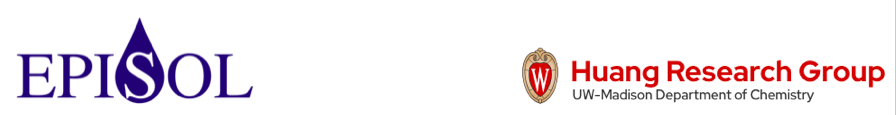

The 3D reference interaction site model (3DRISM) provides an efficient grid-based solvation model to compute the structural and thermodynamic properties of biomolecules in aqueous solutions, in this notebook we will walk through two examples: a neutral, and charged solute. In this notebook we will walk through a 3DRISM calculation on a larger solute - proteins, nucleic acids, and combininations thereof. T
* goals:
  * perform 3DRISM calculations on larger solutes using EPISOL utilizing the python interface
  * determine solvent distibutions around ares of interest
  * workthrough a calculation that fails to converge within the given number of steps
  * place explicit water - oxygens using commands specific to the python interface
  * determine high-energy waters and their importance

In [ ]:
#@title ##Download and Install Episol
#@markdown ($\approx 2$min) Stable as of 07/01/25 eprism v1.2.6
%%capture
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
#%cd ../home/
%cd $HOME/
%mkdir episol
%cd episol
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/fftw/fftw-3.3.8.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded fftw files"
!echo "+++++++++++++++++++"
!tar -xzf fftw-3.3.8.tar.gz
%cd fftw-3.3.8/
#!./configure --prefix=/home/fftw-3.3.8
!./configure --prefix=$HOME/episol/fftw-3.3.8
!make
!make install
%cd ../
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/kernel/release.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded Episol files"
!echo "+++++++++++++++++++"
!tar -xzf release.tar.gz
%cd release/
#!./configure --with-fftw=/home/fftw-3.3.8
!./configure --with-fftw=$HOME/episol/fftw-3.3.8
!make
!make install
#%cd /content
########################### WRAPEPR
!pip install episol
import subprocess
import os
import threading
import pandas as pd
import matplotlib.pyplot as plt
from episol import epipy


In [ ]:
%%capture

#@title Install some python packages for topology generation
#@markdown ($\approx$4min)

#@markdown This will prompt a restart in our colab session, this is necessary, just keep moving

#@markdown (if you are using the notebook offline this wont be necessary, as presumably you'll have your own forcefield to generate topologies)
########################################
#        FOR COLAB USERS ONLY          #
#---------------------------------------#
# if you are running locally you dont need
# condacolab. Just use your local conda dist
########################################
!pip install -q condacolab
import condacolab
condacolab.install()
########################################
#!conda update conda
#!conda install --yes -c conda-forge  python=3.11 numpy=1.26.4 openmm pdbfixer parmed mdanalysis py3dmol rdkit openff-toolkit
#!conda install -y -c conda-forge numpy=1.26.4 openmm=8.3.1 python={PYTHON_VERSION} pdbfixer=1.11 parmed=4.3.0 mdanalysis=2.9.0 py3dmol=2.5.2 rdkit=2025.03.5 openff-toolkit=0.17.0 libgcc
!conda install -y -c conda-forge python=3.12 numpy=1.26.4 openmm=8.3.1 pdbfixer=1.11 parmed=4.3.0 mdanalysis=2.9.0 py3dmol=2.5.2 rdkit=2025.03.5 openff-toolkit=0.17.0 torchvision pymol-open-source
#openmm pdbfixer parmed mdanalysis py3dmol rdkitconda install libgcc

In [1]:
#@title import our downloaded packages
%%capture
!python -m ensurepip --upgrade # since we are using python 3.12 some pkg utils are now obsolete
# after conda-initiate restart colab resets pip
import matplotlib.pyplot as plt
import openmm as mm
from   openmm import app
# fix later
from openmm.app import *
from   openmm.unit import *
import py3Dmol# as pymol
import MDAnalysis as md
import parmed as chem
from openff.toolkit.topology import Molecule, Topology
import numpy as np
import MDAnalysis.transformations as mdt
import pdbfixer
from episol import epipy
%cd /content/

#**Walk Through Calculation:**

First, we will download our desired structure file from the PDB

In [2]:
#@markdown The tutorial will work for essentially any PDB file

#@markdown We encourage the reader to use this tutorial for your own investigation and copy our commands freely
PDB_ID='6OUH' # @param {type:"string", placeholder:"enter a value"}
!wget https://files.rcsb.org/download/"{PDB_ID}.pdb"

--2025-09-18 21:12:42--  https://files.rcsb.org/download/6OUH.pdb
Resolving files.rcsb.org (files.rcsb.org)... 3.169.121.13, 3.169.121.122, 3.169.121.70, ...
Connecting to files.rcsb.org (files.rcsb.org)|3.169.121.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘6OUH.pdb’

6OUH.pdb                [   <=>              ] 227.02K   510KB/s    in 0.4s    

2025-09-18 21:12:43 (510 KB/s) - ‘6OUH.pdb’ saved [232470]



In [2]:
#@markdown use our own
PDB_ID = "output" #@param {type:"string"}

In [3]:
#@markdown Before we get started lets vizualize our PDB structure
disp = py3Dmol.view()
disp.addModel(open(f'{PDB_ID}.pdb', 'r').read(),'pdb')

disp.setStyle('cartoon')
disp.addUnitCell()
disp.zoomTo()
disp.show()

Output hidden; open in https://colab.research.google.com to view.

we can see that our unit cell is very large, using such a large box as input for 3DRISM is possible, but the extra 'blank space' equates to an excessive ammout of RAM
* to combat this we will modify the unit cell to be much smaller, saving cost while maintaining acuuracy
* since we are using a interaction-cutoff of 1nm, we will add a buffer on our PBC cell
* Again, before we run 3DRISM, we need to generate a topology file for our molecule
* we will use PDBFixer to add missing residues, atoms and hydrogens


In [5]:
buffer = 7 # angstroms

* now we clean our PDB file and generate a topology, we wont include any ions in this example
* this protocol will work for essentailly any PDB (within reason) so feel free to download a different PDB and redo the tutorial


In [4]:
#@title this code block cleans our pdb file, writes out to .gro, and generates a topology file
#@markdown We will use PDBFixer to add missing atoms and residues
#@markdown and use MDAnalysis to create a new unit cell and center our protein
#@markdown <1min
include_ions = True #@param {type:'boolean'}
#include_ligands = True #@param {type:'boolean'}
# including ligands will probably break the topology generation
# as there are a lot of goofy ligands in the PDB
# if you want to include ligands see our ligand/small molecule
# tutorial
if include_ions:
  ion_string = "not (element C or element H or element N or element O or element P or element S or element Fe)"
  ions = md.Universe(f'{PDB_ID}.pdb').select_atoms(f'(not protein) and {ion_string}')
  if len(ions) > 0:
          ions.atoms.write('ions.pdb')
          ion = pdbfixer.PDBFixer('ions.pdb')
  else:
    include_ions = False
    print(f'PDB {PDB_ID} does not have any ions')

fixer = pdbfixer.PDBFixer(f'{PDB_ID}.pdb')
forcefield = app.ForceField('amber14-all.xml','amber14/tip3pfb.xml')#charmm36.xml')
"""
stage = "Finding missing residues..."
fixer.findMissingResidues()

stage = "Finding nonstandard residues..."

chains = list(fixer.topology.chains())
keys = fixer.missingResidues.keys()
keys = [i for i in fixer.missingResidues.keys()]
for key in keys:
    chain = chains[key[0]]
    if key[1] == 0 or key[1] == len(list(chain.residues())):
        del fixer.missingResidues[key]
fixer.findNonstandardResidues()

#fixer.findNonstandardResidues()
stage = "Replacing nonstandard residues..."
fixer.replaceNonstandardResidues()
stage = "Removing heterogens..."


fixer.removeHeterogens(keepWater=False)
stage = "Finding missing atoms..."
fixer.findMissingAtoms()
stage = "Adding missing atoms..."
fixer.addMissingAtoms()

stage = "Adding missing hydrogens..."
fixer.addMissingHydrogens(pH=7)
#stage = "Writing PDB file..."
#app.PDBFile.writeFile(fixer.topology, fixer.positions, 'fixed_1ALU.pdb')
stage = "Create System..."
"""
fixer = Modeller(fixer.topology,fixer.positions)

if include_ions:
        fixer.add(ion.topology,ion.positions)

system = forcefield.createSystem(fixer.topology)

#fixer = Modeller(small.topology,small.positions)

struct = chem.openmm.load_topology(fixer.topology,system)

struct.positions = fixer.positions
struct.save(f'{PDB_ID}.top',overwrite=True)
####################### Pass to MDAnalysis and recenter box
temp = md.Universe(struct)#.select_atoms('all')
coords = temp.atoms.positions
"""
trans = [mdt.boxdimensions.set_dimensions([2*np.ceil(np.max(np.abs(coords[:,0]))+buffer),
                                  2*np.ceil(np.max(np.abs(coords[:,1]))+buffer),
                                  2*np.ceil(np.max(np.abs(coords[:,2]))+buffer),
                                  90,90,90]),
                                    mdt.center_in_box(temp.atoms,center='geometry')]
"""
box_x = np.ceil(np.abs(np.max((coords[:,0]))-np.min((coords[:,0])))+buffer)
box_y = np.ceil(np.abs(np.max((coords[:,1]))-np.min((coords[:,1])))+buffer)
box_z = np.ceil(np.abs(np.max((coords[:,2]))-np.min((coords[:,2])))+buffer)
temp.dimensions = [box_x,box_y,box_z,90,90,90]
trans = mdt.center_in_box(temp.atoms,center='geometry')
# we must multiply by 2 because all AF PDBS start at origin I_3*1
temp.trajectory.add_transformations(trans)
temp.atoms.write(f'fixed_{PDB_ID}.gro')
temp.atoms.write(f'fixed_{PDB_ID}.pdb') # py3Dmol can only use pdb unit cell
box,n_atoms,n_res = temp.dimensions[:3], len(temp.atoms), len(temp.residues)
#struct.save(f'fixed_{name}.gro',overwrite=True)
disp = py3Dmol.view()
disp.addModel(open(f'fixed_{PDB_ID}.pdb', 'r').read(),'pdb')
disp.setStyle({'model': -1}, {'cartoon': {}})
disp.addModel(open(f'fixed_{PDB_ID}.pdb', 'r').read(),'pdb')
disp.setStyle({'model': -1}, {'stick': {}})
disp.addUnitCell()
if include_ions:
  temp.select_atoms(f'(not protein) and {ion_string}').atoms.write(f'fixed_{PDB_ID}ions.gro')
  disp.addModel(open(f'fixed_{PDB_ID}ions.gro', 'r').read(),'gro')
  disp.setStyle({'model': -1}, {'sphere': {}})
disp.zoomTo()
disp.show()



/usr/local/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


ValueError: No template found for residue 3912 (MG).  The set of atoms matches MG, but the bonds are different.  Perhaps the chain is missing a terminal group?  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#template

* we can see that our unit cell is much more condensed, it wont matter if our protein clips out of the PBC, as EPISOL uses PME
* now that we have our topology generated we can begin our RISM calculation
* since we are dealing with a larger solute (and we're on colab) we will set our resolution to 1$\mathring{A}$

In [ ]:
pdb = epipy(f"fixed_{PDB_ID}.gro",f"{PDB_ID}.top",convert=True,gen_idc=True)
#pdb.solvent_path= 'episol/release/solvent/'

* as before, we set our saved file name to one relevant as opposed to default names

In [ ]:
pdb.report(f'{PDB_ID}')

In [ ]:
pdb.rism(step=10000,resolution=1)
pdb.err_tol = 1e-08 # we will set a higher tolerance than usual

* for this calculation, we can see that our grid shape is not totally cubic

In [ ]:
pdb.grid


* lets test to get an estimate of how much RAM we will use

In [ ]:
pdb.test()

* now we run!
* since we are using a bit of a larger solute, we will set our number of threads to 2, using the -nt flag
    * < 1min
  


In [ ]:
pdb.kernel(nt=2)

* it looks like our calculation failed to converge within the given step size
* lets take a look at the output
* we will use the python interface to plot the SCF error as a function of step (iteration)

In [ ]:
lscf_err = pdb.err()
fig,ax = plt.subplots()
ax.plot(lscf_err)
ax.set_yscale('log')
ax.set_xlabel('RISM calc. iteration')
ax.set_ylabel('SCF')


* our error tolerance isnt _that_ bad
* but its always better to have a smaller convergence value
* optimizes the self-consistent iterations by considering the
changes made in previous steps. The math form of an n-layer DIIS is
as follows:



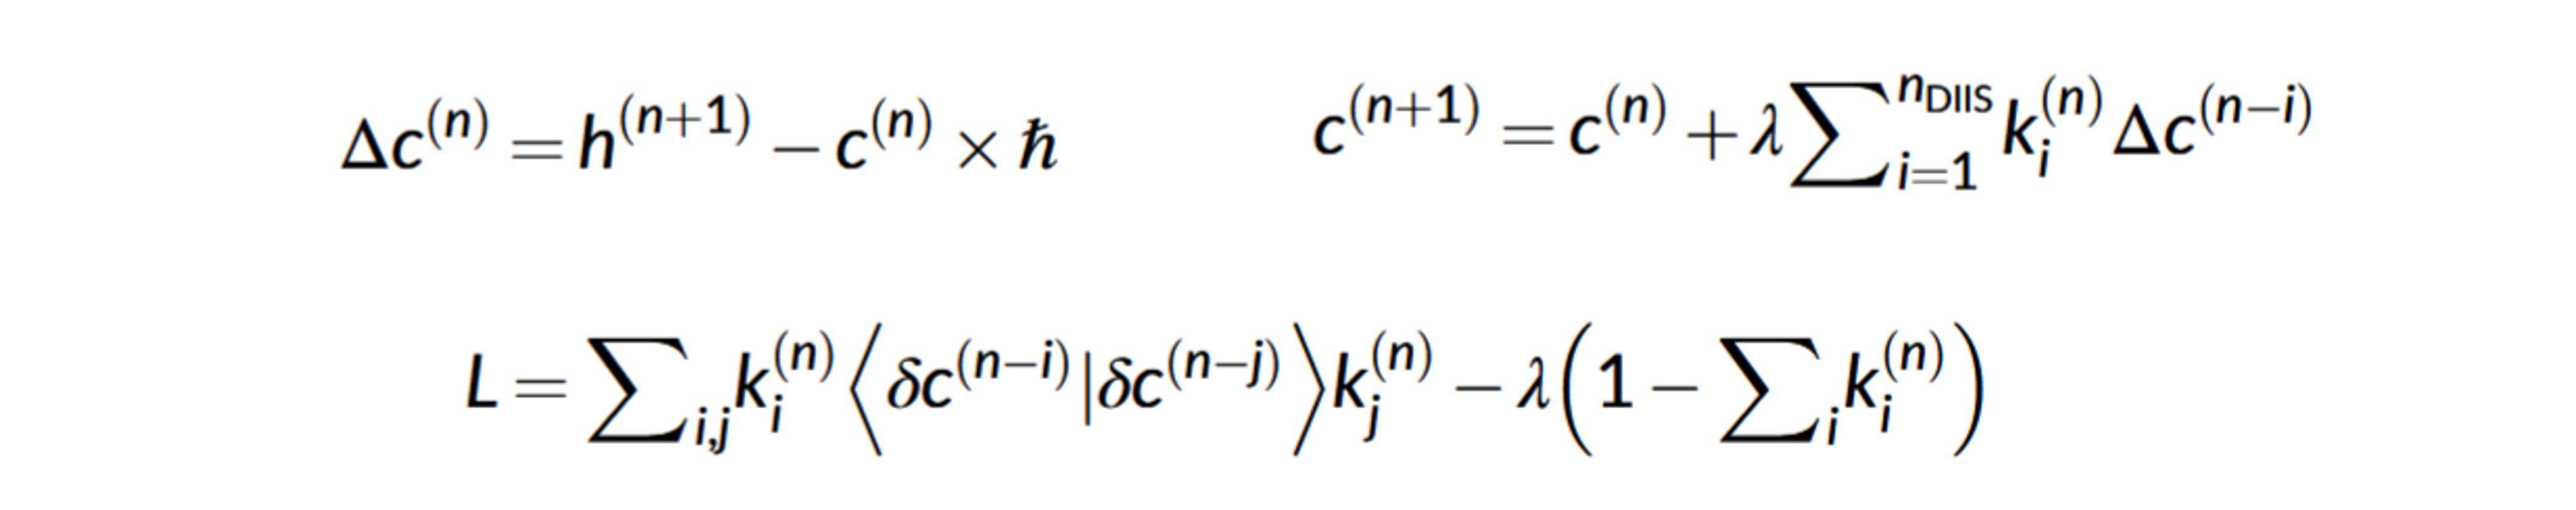

* where the factors $k_i^{n}$ are obtained by solving the DIIS Lagrange equation of historical changes for each grid (bottom)
* a 5-DIIS (std. value) would mean that we would consider the past values at the grid point for previous 5 cycles
* we can set the number of DIIS mixing steps to use
* this will cause our calculation to converge slower, but perhaps overcome local maxima

In [ ]:
pdb.get_help('diis')

* just use the flag shown in the help function to set the parameter i.e. -ndiis means we call .ndiis

In [ ]:
pdb.ndiis = 15
pdb.report('diis_increase_pdb')

* increasing the N-DIIS will also increase our allocated RAM usage

In [ ]:
pdb.test()

* lets run now with increased DIIS (< 1min)
* since we are have a larger solute, we will use al available threads (2)

In [ ]:
pdb.kernel(nt=2)

* comparing the error of the two runs we can see that increasing the DIIS also increases our convergence rate and helps mainintain a 'smoother' error curve

In [ ]:
diis_scf_err = pdb.err()
fig,ax = plt.subplots()
ax.plot(lscf_err,label="$\delta^{SCF}$ NDIIS = 5 (stnd.)")
ax.plot(diis_scf_err,label=f"$\delta^{{SCF}}$ NDIIS = {pdb.ndiis}")
ax.set_yscale('log')
ax.set_xlabel('RISM calc. iteration')
ax.set_ylabel('SCF')
ax.legend()
fig.tight_layout()

* if you so desire, we can run a test using DIIS increase

In [ ]:
#@title DIIS increase test
#@markdown $\approx$ 5min (not required)
#%%capture
tmp = epipy(f"fixed_{PDB_ID}.gro",f"{PDB_ID}.top",convert=True,gen_idc=True)
out = []
for i in range(0,10,2):
  tmp.report(f'ndiis_{i}')
  tmp.ndiis = i
  tmp.kernel()
  out.append(tmp.err())

fig,ax = plt.subplots(figsize=(10,5))
ii = [i for i in range(0,10,2)]
for i,vals in zip(ii,out[1:]):
  ax.plot(vals,label=f"NDIIS = {i+2}")
  if i == 2: # we will show our errors in order (for asthetic reasons)
    ax.plot(lscf_err,label="NDIIS = 5")
ax.plot(diis_scf_err,label="NDIIS = 10")

ax.set_yscale('log')
ax.set_xlabel('SCF iteration')
ax.set_ylabel('$\delta^{SCF}$')
ax.legend()
fig.tight_layout()

**visualizing resutls**

* lets extract our atomic-density from the calculation

In [ ]:
g_r = pdb.select_grid('guv')

* we can now visualize our results

In [ ]:
z_slice = 27 # @param {type:"slider", min:1, max:91, step:1}
fig,ax = plt.subplots()
#z_slice = 10
p = ax.pcolormesh(g_r[z_slice])
ax.set_ylabel(f'y grid / {pdb.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {pdb.resolution}$\\mathring{{A}}$')
#ax.set_ylim(20,100)
#ax.set_xlim(10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
fig.suptitle(f'$g(\\vec{{r}})$ at slice {z_slice*pdb.resolution} $\\mathring{{A}}$')

* lets make use of epipy's select commands to investigate our RISM calculation
* epipy uses similar selection language to MDAnalysis and MDtraj
* here, we will select densities around 4A of all of our proteins residues

In [ ]:
selected_grid = pdb.select_grid('guv around 4 resname LYS')

In [ ]:
#@markdown lets vizualize our selected areas
z_slice = 25 # @param {type:"slider", min:0, max:91, step:1}
fig,ax = plt.subplots()#figsize=(10,3))
#z_slice = 10
p = ax.pcolormesh(selected_grid[z_slice])
ax.set_ylabel(f'y grid / {pdb.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {pdb.resolution}$\\mathring{{A}}$')
#ax.set_ylim(None,20)#,100)
#ax.set_xlim(None,20)#10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
ax.set_title(f'$g(\\vec{{r}})$ at slice {z_slice*pdb.resolution} $\\mathring{{A}}$')


* this allows us to better analyze our system
* lets say for example, we want to see our $g(r)$ around our individual residues (≈ 20s)

In [ ]:
#@markdown
# first we create a list of the residues that are in our protein
pdb_residues = np.unique(md.Universe(f'fixed_{PDB_ID}.gro').select_atoms('protein').resnames)
# then make a dictionary of these names
density_dict = dict(zip(pdb_residues,[[] for _ in pdb_residues]))

for name in pdb_residues:
  ss = pdb.select_grid(f'guv around 4 resname {name}')
  # when doing this calculation we must ignore the NaN values
  density_dict[name] = np.ma.array(ss, mask=np.isnan(ss)).mean()
  # we will just take the mean value of our g(r)

fig,ax = plt.subplots(figsize=(10,3))
for name in density_dict.keys():
  ax.bar(name, density_dict[name])
ax.set_ylabel("$\\langle g(r)\\rangle$")
ax.set_title("Mean $g(\\vec{r})$ in  first solvation shell")

* we can select other values too, for example free energy around our residues

In [ ]:
#@markdown
# first we create a list of the residues that are in our protein
pdb_residues = np.unique(md.Universe(f'fixed_{PDB_ID}.gro').select_atoms('protein').resnames)
# then make a dictionary of these names
density_dict = dict(zip(pdb_residues,[[] for _ in pdb_residues]))

for name in pdb_residues:
  ss = pdb.select_grid(f'uuv around 4 resname {name}')
  # when doing this calculation we must ignore the NaN values
  density_dict[name] = np.ma.array(ss, mask=np.isnan(ss)).mean()
  # we will just take the mean value of our g(r)

fig,ax = plt.subplots(figsize=(10,3))
for name in density_dict.keys():
  ax.bar(name, density_dict[name])
ax.set_ylabel("$\\langle g(r)\\rangle$")
ax.set_title("Mean $U(\\vec{r})$ in  first solvation shell")

* if we want to select more specific we can supply an array of our corrdinates we want to select around
* this can be any arbitrary coordinates
* for now, we will use MDAnalysis to select the Nitrogens in our LYS residues and look at $g(r)$ within the first solvation shell
* and compare this with oxygen

In [ ]:
sel = md.Universe(f'fixed_{PDB_ID}.gro').select_atoms('(resname LYS) and (name N)').positions
oo = pdb.select_grid('coul around 4',sel)

In [ ]:
sel = md.Universe('fixed_6OUH.gro').select_atoms('(resname LYS) and (name N)').positions
oo = pdb.select_grid('coul around 4',sel)#resname LYS')
z_slice = 27 # @param {type:"slider", min:1, max:91, step:1}
fig,ax = plt.subplots()
#z_slice = 10
p = ax.pcolormesh(oo[z_slice])
ax.set_ylabel(f'y grid / {pdb.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {pdb.resolution}$\\mathring{{A}}$')
#ax.set_ylim(20,100)
#ax.set_xlim(10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
fig.suptitle(f'$g(\\vec{{r}})$ at slice {z_slice*pdb.resolution} $\\mathring{{A}}$')

* We can rerun with higher resolution if we want, but for now we will leave it a little-pixelated
* lets proceed with our investigation by checking our interaction energy on each grid point

* Now lets place waters on our grid
* we will select the top 100 atomic-density ( $g(\vec{r})$ ) peaks and place oxygen

In [ ]:
number_waters_to_place = len(md.Universe(f'{PDB_ID}.pdb').select_atoms('resname HOH'))
placed_waters = pdb.placement(number_waters_to_place,filename='guv_diis_increase_pdb.txt',write_pdb=True,outname='placed_waters')

In [ ]:
#@markdown Lets align our original PDB file to our modified and shifted RISM pdb
%%capture
u1 = md.Universe(f'fixed_{PDB_ID}.gro')
u2 = md.Universe(f'placed_waters.pdb')
#u2.dimensions = [il6.grid[0],il6.grid[1],il6.grid[2],90,90,90]
md.Merge(u1.atoms,u2.atoms).atoms.write('merged_pdb.pdb')
from pymol import cmd
cmd.load(f"{PDB_ID}.pdb")
cmd.load("merged_pdb.pdb")
cmd.align("polymer and name CA and (merged_pdb)",f"polymer and name CA and ({PDB_ID})",quiet=0,object="aln",reset=1)
#cmd.align("polymer and name CA and (1ALU)","polymer and name CA and (merged_pdb)",quiet=0,object="aln",reset=1)
cmd.save("aligned_merged_pdb.pdb","merged_pdb")
cmd.delete(f"{PDB_ID}")
cmd.delete("merged_pdb")
cmd.delete("aligned_merged_pdb")

In [ ]:
#@markdown View our placed waters
md.Universe("aligned_merged_pdb.pdb").select_atoms("resname HOH").atoms.write('aligned_waters.pdb')
md.Universe(f"{PDB_ID}.pdb").select_atoms("resname HOH").atoms.write('orig_waters.pdb')
disp = py3Dmol.view()
disp.addModel(open(f'{PDB_ID}.pdb','r').read(),'pdb')
disp.setStyle({'model': -1}, {'cartoon': {'color':'grey'}})

disp.addModel(open('aligned_waters.pdb', 'r').read(),'pdb')
#disp.addModel(open('il6_waters.pdb', 'r').read(),'pdb',)
#disp.setStyle({'model': -1}, {'sphere': {}})
disp.setStyle({'model': -1}, {'sphere': {'color':'cyan'}})
disp.addModel(open('orig_waters.pdb', 'r').read(),'pdb')
disp.setStyle({'model': -1}, {'sphere': {'color':'red'}})
#disp.addUnitCell()
disp.addLabel('Cyan: RISM , Red: True')#,"bottomCenter")#{'alignment':"bottomCenter"},{'fontColor':'cyan'})#:{'color':'cyan'}})#,{'color':'red'})
disp.setHoverable({},True,'''function(atom,viewer,event,container) {
                   if(!atom.label) {
                    atom.label = viewer.addLabel(atom.resn+":"+atom.atom,{position: atom, backgroundColor: 'mintcream', fontColor:'black'});
                   }}''',
               '''function(atom,viewer) {
                   if(atom.label) {
                    viewer.removeLabel(atom.label);
                    delete atom.label;
                   }
                }''')
disp.zoomTo()

disp.show()

In [ ]:
#@markdown now lets measure RMSD between nearest neighbors
from MDAnalysis.lib.distances import capped_distance
from scipy.optimize import linear_sum_assignment
def optimal_mean_squared_distance(list1, list2):
    #list1 = np.array(list1)
    #list2 = np.array(list2)
    n = len(list1)
    assert len(list2) == n, "Lists must be the same length"
    # Build the cost matrix: mean squared distances
    cost_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cost_matrix[i, j] = np.mean((list1[i] - list2[j]) ** 2)
    # Use the Hungarian algorithm to find the minimal total MSD pairing
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # Extract the pairs and compute total mean squared distance
    pairs = [(list1[i], list2[j]) for i, j in zip(row_ind, col_ind)]
    total_msd = cost_matrix[row_ind, col_ind].sum()
    mean_msd = total_msd / n
    return mean_msd, pairs
###################################
def minimize_rmsd(distances,pairs,threshold_dist=999):
    """ I uh made this
    to search through distances and corrresponding pairs, the output is the pair index that has the smallest distance between
    indexd originial pairs, i.e. pair 1,2,3 the output would be whatever corresponding unique pair minimizes the distance
    it finishes suspeicously fast....
    returns a list of the unique pair"""
    d = dict(zip(np.unique(pairs[:,0]),np.empty(len(np.unique(pairs[:,0])))))
    already_used = []
    for item in d.keys():
        min_dist = threshold_dist
        for pair, dist in zip(pairs[np.where(pairs[:,0] == item)][:,1],distances[np.where(pairs[:,0] == item)]):
            if (min_dist > dist) and (len(np.where(np.array([d[i] for i in d.keys() if i != item]) == pair)[0]) < 1):
                d[item] = int(pair)
                min_dist = dist
    return [int(i) for i in list(d.values())]

placed  = md.Universe('aligned_waters.pdb').select_atoms("resname HOH").positions
tru = md.Universe(f'{PDB_ID}.pdb').select_atoms("resname HOH").positions
# organize the groups for the next calc
if len(tru) > len(placed):
    print('tru',len(tru),'vv',len(placed))
    placed, tru = tru, placed
    print('tru',len(tru),'vv',len(placed))
# then find the distances and pairs, cap distance at 50 to save cost
pairs, distances = capped_distance(tru,placed,50,return_distances=True,method='pkdtree')
print("distance computed")
new_vv = placed[minimize_rmsd(distances=distances,pairs=pairs)]
# select the atoms from the largest group that are closest to the smaller group
del distances
del pairs
msd,_ = optimal_mean_squared_distance(tru,new_vv)
print("==================")
print("==================")
print("RMSD",msd**0.5)
print("==================")
print("==================")

* lets use our selection commands to get our free energy values of the waters we just placed
* here, we use the coordinates from our placement, and use them to select the energies from our calculation

In [ ]:
placed_water_energies = pdb.select_grid('uuv get',placed_waters)

* we can now add these energies into our waters pdb as tempfactors
* this is the easiest way to vizualize them in VMD/PyMol
* for our jupyter embedded model we will just select the water with the highest energy

In [ ]:
#@markdown View Results
placed_waters = md.Universe('aligned_waters.pdb')
placed_waters.add_TopologyAttr('tempfactors',placed_water_energies)
energy_of_highest_water = np.max(np.abs(placed_waters.atoms.tempfactors))
high_energy_water_index = np.where(placed_water_energies == energy_of_highest_water)[0][0]
placed_waters.select_atoms(f'id {high_energy_water_index+1}').write('energy.pdb')

disp = py3Dmol.view()
disp.addModel(open(f'energy.pdb','r').read(),'pdb')
disp.setStyle({'model': -1}, {'sphere': {'color':{'opacity':0.7,'colorscheme':{'prop':'b'}}}})#,'gradient':'sinebow','min':np.min(placed_waters.atoms.tempfactors),'max':np.max(placed_waters.atoms.tempfactors)}}}}) #'cyan'}})
#view.addSurface(py3Dmol.VDW,{'opacity':0.7,'colorscheme':{'prop':'b','gradient':'sinebow','min':0,'max':70}})

disp.addModel(open(f'{PDB_ID}.pdb', 'r').read(),'pdb')
disp.setStyle({'model': -1}, {'stick': {}})#{'color':'grey'}})
#disp.addUnitCell()
if include_ions:
  md.Universe("aligned_merged_pdb.pdb").select_atoms(f'(not protein) and {ion_string}').atoms.write('ions.pdb')
  disp.addModel(open('ions.pdb', 'r').read(),'pdb')
  disp.setStyle({'model': -1}, {'sphere': {}})#{'color':'cyan'}})

disp.addLabel(f'Cyan: High energy RISM water {energy_of_highest_water:0.3f}')#,"bottomCenter")#{'alignment':"bottomCenter"},{'fontColor':'cyan'})#:{'color':'cyan'}})#,{'color':'red'})

disp.zoomTo()
disp.setHoverable({},True,'''function(atom,viewer,event,container) {
                   if(!atom.label) {
                    atom.label = viewer.addLabel(atom.resn+":"+atom.atom+":"+atom.b,{position: atom, backgroundColor: 'mintcream', fontColor:'black'});
                   }}''',
               '''function(atom,viewer) {
                   if(atom.label) {
                    viewer.removeLabel(atom.label);
                    delete atom.label;
                   }
                }''')
disp.show()

In [ ]:
#@markdown View our placed waters
#md.Universe("aligned_merged_pdb.pdb").select_atoms("resname HOH").atoms.write('aligned_waters.pdb')
#md.Universe(f"{PDB_ID}.pdb").select_atoms("resname HOH").atoms.write('orig_waters.pdb')
placed_waters = md.Universe('aligned_waters.pdb')
placed_waters.add_TopologyAttr('tempfactors',placed_water_energies)
placed_waters.atoms.write('aligned_waters.pdb')

disp = py3Dmol.view()
disp.addModel(open(f'{PDB_ID}.pdb','r').read(),'pdb')
disp.setStyle({'model': -1}, {'cartoon': {'color':'grey'}})

disp.addModel(open(f'{PDB_ID}.pdb','r').read(),'pdb')
disp.setStyle({'model': -1}, {'stick': {'color':'grey'}})

#disp.addModel(open('aligned_merged_pdb.pdb', 'r').read(),'pdb')
#u1 = md.Universe('fixed_1ALU.gro')
#disp.addModel(open('fixed_1ALU.gro','r').read(),'gro')
#u2 = md.Universe('il6_waters.pdb')
#disp.setStyle('cartoon')
disp.addModel(open('aligned_waters.pdb', 'r').read(),'pdb')
#disp.addModel(open('il6_waters.pdb', 'r').read(),'pdb',)
#disp.setStyle({'model': -1}, {'sphere': {}})
disp.setStyle({'model': -1}, {'sphere': {'color':'cyan'}})
disp.addModel(open('orig_waters.pdb', 'r').read(),'pdb')
disp.setStyle({'model': -1}, {'sphere': {'color':'red'}})
#disp.addUnitCell()
disp.addLabel('Cyan: RISM , Red: True')#,"bottomCenter")#{'alignment':"bottomCenter"},{'fontColor':'cyan'})#:{'color':'cyan'}})#,{'color':'red'})
disp.setHoverable({},True,'''function(atom,viewer,event,container) {
                   if(!atom.label) {
                    atom.label = viewer.addLabel(atom.resn+":"+atom.atom+":"+atom.b,{position: atom, backgroundColor: 'mintcream', fontColor:'black'});
                   }}''',
               '''function(atom,viewer) {
                   if(atom.label) {
                    viewer.removeLabel(atom.label);
                    delete atom.label;
                   }
                }''')
disp.zoomTo()

disp.show()

# DONE

We encourage you to play around with this tutorial and substitute your own PDB file  

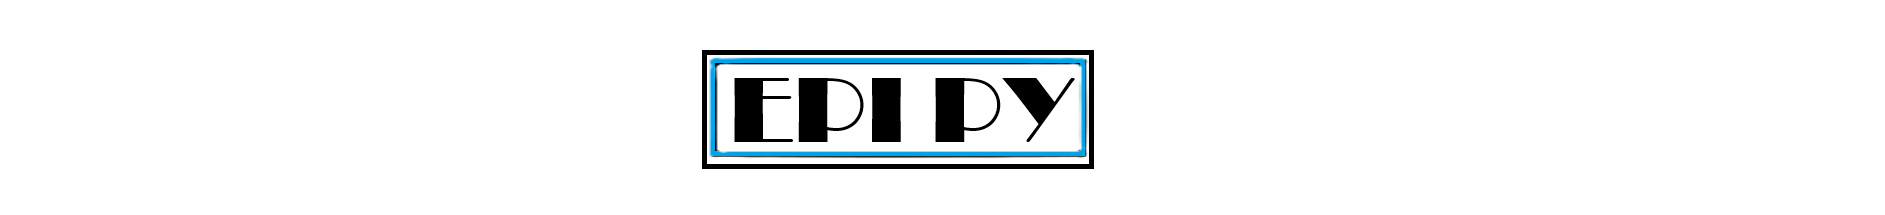